<a href="https://colab.research.google.com/github/covinolab/sbi_for_smfe_tutorial/blob/main/sbi_smfe_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation-based inference for single-molecule force-spectroscopy

In [5]:
!pip install bottleneck
!pip install sbi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import numba as nb
import scipy.stats as stats
import torch
import bottleneck as bn
import matplotlib.pyplot as plt

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

1. ## The Model

Let's consider the simplest model for a single molecule-force spectroscopy experiment.\
The free energy profile of the protein end-to-end distance is modeled as a symmetric double-well, with the barrier height being the only variable parameter.

The molecular free energy profile $G_0(x)$ is modeled by the following equation:

$G_0(x) = \Delta G^{\ddagger}\cdot f(x/x^{\ddagger})$

$f(x) = 
\begin{cases}
- 2x^2,\ for\ 0\leq |x| \leq 1/2\\
2(|x| - 1)^2,\ for\ 1/2 < |x|\\
\end{cases}$

The free energy of the molecular extension and the measured extension is described by:

$G(q, x) = G_0(x) + \frac{\kappa_l}{2}(x - q)^2$

A single realization of a single-molecule experiment can be simulated by solving Brownian motion inside the free energy surface $G(x, q)$:

$q(t + \Delta t) = q(t) -\beta\partial_q G(q, x)\cdot D_q \Delta t + \sqrt{2 D_q \Delta t}\cdot R_q(t)$

$x(t + \Delta t) = x(t) -\beta\partial_x G(q, x)\cdot D_x \Delta t + \sqrt{2 D_x \Delta t}\cdot R_x(t)$

In the following cell, we build a simple but efficient function to evaluate the latter equations.

We used the following names for the variables in the code and the formulas.

`deltaG` = $\Delta G^{\ddagger}$

`x0` and `q0` = Intial position

`Dx` = $D_x$

`Dq` = $D_q$

`deltax` = $x^{\ddagger}$

`k` = $\kappa_l$

In [7]:
@nb.jit(nopython=True, fastmath=True)
def double_well_integrator(x0=-1.5, q0=-1.5, Dx=1, Dq=1, deltaG=6, deltax=1.5, k=3, T=10000, max_N=1e5):
    '''
    kbT = 1 
    x0      Inital x position
    q0      Inital q position
    Dx      Diffusion constant in x direction
    Dq      Diffusion constant in q direction
    T       Total length of the trajectory
    N_max   Maximal number of saved frames
    deltaG  Height of the potential barrier
    deltax  Distance between potential minima
    k       Coupling between x and q
    '''
    
    dt = 5e-4 / Dx
    N = int(T / dt)
    fs = 1
    
    if max_N < N:
        fs = int(N / max_N)

    n = int(N / fs)
    
    Ax = Dx * dt
    Bx = np.sqrt(2 * Ax)
    Aq = Dq * dt
    Bq = np.sqrt(2 * Aq)

    q = np.zeros(n)
    x = np.zeros(n)
    
    gq = np.random.standard_normal(size=n)
    gx = np.random.standard_normal(size=n)

    q[0] = q0
    x[0] = x0

    xold = x0
    qold = q0

    for i in range(1, N):

        # forces evaluation
        x_res = xold / deltax
        x_abs = np.abs(x_res)

        if x_abs <= 0.5:
            Fx = deltaG / deltax * (4 * x_res) - k * (xold - qold)
        else:
            Fx = - deltaG / deltax * (4 * (x_abs - 1) * np.sign(x_res)) - k * (xold - qold)
        Fq = k * (xold - qold)

        # Drawing noise 
        if i%n == 0:
            gq = np.random.standard_normal(size=n)
            gx = np.random.standard_normal(size=n)

            
        # integration
        xnew = xold + Ax * Fx + Bx * gx[i%n]
        qnew = qold + Aq * Fq + Bq * gq[i%n]

        if (i % fs) == 0:
            q[int(i / fs)] = qnew
            x[int(i / fs)] = xnew

        xold = xnew
        qold = qnew

    return x, q

We can run a single simulation in the double-well free energy surface with $D_q/D_x = 1$, $\Delta G^{\ddagger}$ = 6 $k_{\mathrm{B}}T$ and $\kappa_l = 3$ $k_{\mathrm{B}}T/[q^2]$
by evaluating the function `double_well_integrator` with the corresponding arguments.

In [8]:
x, q = double_well_integrator(x0=-1.5, q0=-1.5, Dx=1, Dq=1, deltaG=6, deltax=1.5, k=3, T=10000, max_N=1e5)

The function returns the projected trajectory along q and x. We visualize the trajectory in the following cell.\
In panel A, we plot the two-dimensional coordinates of the trajectory. In panels B and C the projected trajectories along q and x are plotted and on panel C the histograms of the trajectories of q and x are.

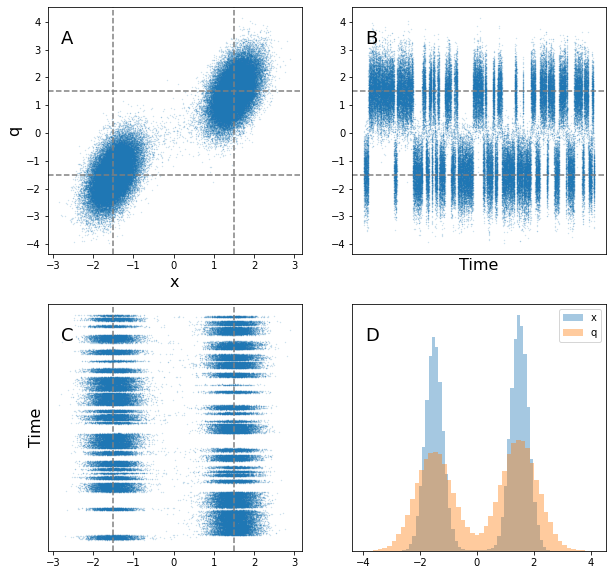

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
time = np.linspace(0, 1, int(1e5))

axes[0][0].scatter(x, q, s=0.1, alpha=0.3)
axes[0][0].set_xlabel('x', fontsize=16)
axes[0][0].set_ylabel('q', fontsize=16)
axes[0][0].axhline(-1.5, color='gray', linestyle='--')
axes[0][0].axhline(1.5, color='gray', linestyle='--')
axes[0][0].axvline(-1.5, color='gray', linestyle='--')
axes[0][0].axvline(1.5, color='gray', linestyle='--')

axes[0][1].scatter(time, q, s=0.1, alpha=0.3)
axes[0][1].set_xticks([])
axes[0][1].set_xlabel('Time', fontsize=16)
axes[0][1].axhline(-1.5, color='gray', linestyle='--')
axes[0][1].axhline(1.5, color='gray', linestyle='--')

axes[1][0].scatter(x, time, s=0.1, alpha=0.3)
axes[1][0].set_yticks([])
axes[1][0].set_ylabel('Time', fontsize=16)
axes[1][0].axvline(-1.5, color='gray', linestyle='--')
axes[1][0].axvline(1.5, color='gray', linestyle='--')

_ = axes[1][1].hist(x, density=True, bins=50, alpha=0.4, label='x')
_ = axes[1][1].hist(q, density=True, bins=50, alpha=0.4, label='q')
axes[1][1].set_yticks([])
axes[1][1].legend()

for idx, ax in enumerate(fig.get_axes()):
    ax.annotate('ABCD'[idx], xy=(0.05, 0.85), fontsize=18, xycoords='axes fraction')

2. ## The Simulator
The simulator should recreate the experimental setting and also includes the computation of summary statistics.\
The summary statistics are used to learn the posterior.\
Since in the experiment we only have access to the measured extension, the simulator only returns the summarized trajectory of the measured extension `q`.

In [12]:
def propagator(x, t=1):
    return x[t:] - x[:-t]


@nb.jit(nopython=True)
def transitions_count(x):
    freq = 0
    for i in range(len(x)):
        if np.sign(x[i]) == -np.sign(x[i+1]):
            freq += 1
    return freq


def prop_stats(x, t):
    delta_x = propagator(x, t=t)
    return np.mean(delta_x), np.std(delta_x), stats.skew(delta_x), stats.kurtosis(delta_x)


def double_well_simulator(params):

    # Simulate the trajectory
    params = np.array(params, dtype=float)
    _, q = double_well_integrator(
        Dx=1, 
        Dq=(10 ** params[0]), 
        deltaG=params[1], 
        deltax=1.5, 
        k=3, 
        T=10000, 
        max_N=2e5
    )
    
    # Calculate trajectory features
    delta_1 = prop_stats(q, 1)
    delta_10 = prop_stats(q, 10)
    delta_100 = prop_stats(q, 100)
    delta_1k = prop_stats(q, 1000)
    delta_10k = prop_stats(q, 10000)
    freq = transitions_count(bn.move_mean(q, window=4000))

    # Summary statistics
    features = [
        freq, np.mean(q), np.std(q), stats.skew(q), stats.kurtosis(q),
        delta_1[0], delta_1[1], delta_1[2], delta_1[3],
        delta_10[0], delta_10[1], delta_10[2], delta_10[3],
        delta_100[0], delta_100[1], delta_100[2], delta_100[3],
        delta_1k[0], delta_1k[1], delta_1k[2], delta_1k[3],
        delta_10k[0], delta_10k[1], delta_10k[2], delta_10k[3]
    ]
    
    return torch.tensor(features)

3. ## Learning the posterior

### Defining the prior

First, we need to define our prior $p(\theta)$, which encodes all our current knowledge about the parameters. 
In this case, we only want to perform inference for two parameters: The barrier height $\Delta G^{\ddagger}$ and the ratio of diffusion coefficients $D_q/D_x$.\
We choose simple uniform priors, and build a PyTorch distribution representing our prior with `utils.BoxUniform`

In [13]:
dG_lims = (3, 8)
logD_lims = (-1, 1)

In [14]:
prior = utils.BoxUniform(low=torch.tensor([logD_lims[0], dG_lims[0]]), high=torch.tensor([logD_lims[1], dG_lims[1]]))

To check that everything works accordingly we can use `prepare_for_sbi` in order to check our prior and our simulator.

In [15]:
double_well_simulator, prior = prepare_for_sbi(double_well_simulator, prior)

### Density estimation to approximate the posterior

Finally, we can start to build our posterior.\
The `SNPE` class implemented in the SBI toolkit can do everything for us in PyTorch.
We initiate an `SNPE` object and give it our prior and the density estimation method as an argument.\
In this case, we use a simple mixture density network by specifying `density_estimator='mdn'`.

In [16]:
inference = SNPE(prior=prior, density_estimator='mdn')

To train approximate the posterior we generate our training data using our simulator.\
Therefore we darw parameters $\theta_i\sim p(\theta)$ and use them to run run our model $q_i\sim  \mathcal{M}(\theta)$.\
In the end, we have a dataset containing parameters and corresponding simulations $\mathcal{D} = \{(\theta_i, q_i)\}_{i=0}^N$

In [20]:
theta, x = simulate_for_sbi(double_well_simulator, prior, num_simulations=100, num_workers=2, simulation_batch_size=1)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

We train our neural network on $\mathcal{D}$ to approximate the posterior.

In [21]:
density_estimator = inference.append_simulations(theta, x).train(show_train_summary=True)

 Neural network successfully converged after 111 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 111
        Best validation performance: -1.4447
        -------------------------
        


In [22]:
posterior = inference.build_posterior(density_estimator)

4. ## Generating an synthetic observation

To test how well our approximate posterior, we can use our simulator $\mathcal{M}(\theta)$ to generate a synthetic observation $q_{obs} \sim \mathcal{M}(\theta_{obs})$.\
Evaluating our posterior with the observation $q_{obs}$ we can see whether the true parameter $\theta_{obs}$ is supported by the posterior. 

In [23]:
true_params = torch.tensor([[-0.5, 5]])

In [24]:
observation = double_well_simulator(true_params)

5. ## Inferring the parameters

In the following plot, we can see the posterior given our generated observation $q_{obs}$.
The red line indicates the true parameter $\theta_{obs}$

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pyknos/mdn/mdn.py:290: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  chosen_precision_factors,


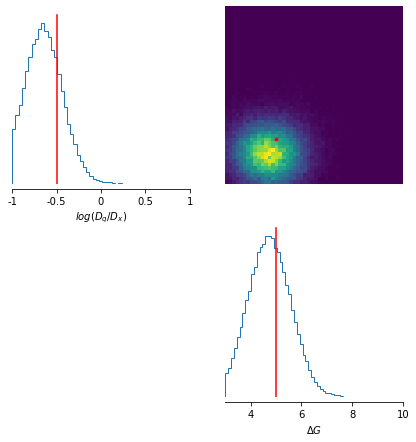

In [25]:
samples = posterior.sample((50000,), x=observation)
_ = analysis.pairplot(
    samples,
    limits=[logD_lims, dG_lims],
    figsize=(7,7),
    points=true_params, 
    points_offdiag={'markersize': 6},
    points_colors='r', 
    labels=['$log(D_q/D_x)$', '$\Delta G$']
)

5. ## Sequential posterior estimation

If we are only interested in a the posterior for a single observation we can sequentially estimate the posterior, which needs less simulations. 
In the following sequentially estimate the posterior for the precomputed observation $q_{obs}$

In [28]:
seq_posteriors = []
proposal = prior
num_rounds = 5

seq_inference = SNPE(prior=prior, density_estimator='mdn')
for _ in range(num_rounds):
    theta, x = simulate_for_sbi(double_well_simulator, proposal, num_simulations=10, num_workers=2, simulation_batch_size=1)
    seq_density_estimator = seq_inference.append_simulations(theta, x, proposal=proposal).train()
    seq_posterior = seq_inference.build_posterior(density_estimator)
    seq_posteriors.append(seq_posterior)
    proposal = seq_posterior.set_default_x(observation)

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 120 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 58 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 31 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Running 10 simulations in 10 batches.:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with non-atomic loss
 Neural network successfully converged after 21 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

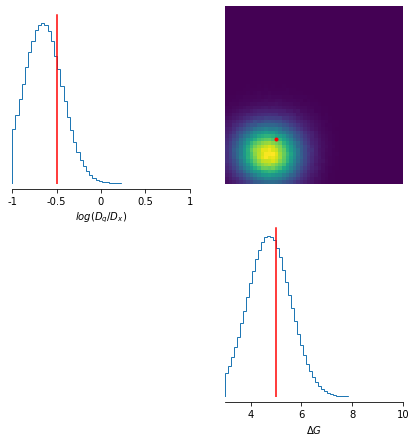

In [27]:
samples = seq_posterior.sample((1000000,))
_ = analysis.pairplot(
    samples,
    limits=[logD_lims, dG_lims],
    figsize=(7,7),
    points=true_params,
    points_offdiag={'markersize': 6},
    points_colors='r',
    labels=['$log(D_q/D_x)$', '$\Delta G$']
)